# 1 Import Packages

In [1]:
import xarray as xr
import numpy as np
import os
import datetime

import pandas as pd
import matplotlib.pyplot as plt

import src.config as config
import src.utils as utils

import math
from tqdm import tqdm

import tensorflow as tf

2023-03-14 11:46:16.248621: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2 Metadata

In [2]:
lev_index   = 0
kfold_index = 0
experiment_name = "cv_samplestandardized"
datetime_string = "reg_search"
reg_min = -2
reg_max = 0

In [3]:
reg_list = np.logspace(reg_min, reg_max, num=10)

In [4]:
ml_transform_path = os.path.join(config.data_pro_path,"ml_transform", experiment_name)

In [5]:
train_x_filename = "train_x_lev_{}_{}.nc".format(lev_index, kfold_index)
valid_x_filename = "valid_x_lev_{}_{}.nc".format(lev_index, kfold_index)

train_y_filename = "train_y_{}_{}.nc".format(lev_index, kfold_index)
valid_y_filename = "valid_y_{}_{}.nc".format(lev_index, kfold_index)

# 3 Load Data

In [6]:
train_x_xr = xr.open_dataset(os.path.join(ml_transform_path, train_x_filename)).compute()
valid_x_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_x_filename)).compute()

In [7]:
train_y_xr = xr.open_dataset(os.path.join(ml_transform_path, train_y_filename)).compute()
valid_y_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_y_filename)).compute()

# 4 Processing

## 4.1 Stacking dimensions

In [8]:
train_x_xr_stack = train_x_xr.stack(sample=("realization","time"), feature = ("lon","lat"))
valid_x_xr_stack = valid_x_xr.stack(sample=("realization","time"), feature = ("lon","lat"))

In [9]:
train_y_xr_stack = train_y_xr.stack(sample=("realization","time"))
valid_y_xr_stack = valid_y_xr.stack(sample=("realization","time"))

In [10]:
valid_sample_coords = valid_y_xr_stack.sample
train_sample_coords = train_y_xr_stack.sample

## 4.2 Transform to numpy and mask nans with zeros

In [11]:
train_x_ml_np = np.nan_to_num(train_x_xr_stack["rho"].transpose("sample",...),0)
valid_x_ml_np = np.nan_to_num(valid_x_xr_stack["rho"].transpose("sample",...),0)

train_y_ml_np = train_y_xr_stack["atlantic_moc"].values
valid_y_ml_np = valid_y_xr_stack["atlantic_moc"].values

In [12]:
lon = train_x_xr_stack.lon
lat = train_x_xr_stack.lat

# 5 Model

In [13]:
def gen_model(reg_value):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(10, activation="LeakyReLU", kernel_regularizer = tf.keras.regularizers.L2(l2=reg_value), input_shape =(14520,)))
    #model.add(tf.keras.layers.BatchNormalization())
    #model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    #model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(100, activation="LeakyReLU"))

    #model.add(tf.keras.layers.BatchNormalization())
    #model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    #model.add(tf.keras.layers.Dense(10, activation="relu"))
    #model.add(tf.keras.layers.BatchNormalization())

    #model.add(tf.keras.layers.Dropout(0.5))
    #model.add(tf.keras.layers.Dense(50, activation="relu"))
    #model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(1, activation="linear", bias_initializer=tf.keras.initializers.constant(value=20)))
    
    return model
    

In [27]:
from tensorflow.keras.callbacks import Callback

class TrainValMSEDiff(Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        
        train_x_tensor = tf.convert_to_tensor(train_x_ml_np, dtype=tf.float32)
        valid_x_tensor = tf.convert_to_tensor(valid_x_ml_np, dtype=tf.float32)
        
        train_y_tensor = tf.convert_to_tensor(train_y_ml_np, dtype=tf.float32)
        valid_y_tensor = tf.convert_to_tensor(valid_y_ml_np, dtype=tf.float32)
        
        train_mse = model.evaluate(train_x_tensor, train_y_tensor, batch_size = 15000)
        valid_mse = model.evaluate(valid_x_tensor, valid_y_tensor, batch_size = 15000)
        
        tf.keras.backend.clear_session()
        diff_mse  = train_mse - valid_mse
        
        logs["train_mse_epoch_end"] = train_mse
        logs["valid_mse_epoch_end"] = valid_mse
        logs["diff_mse_epoch_end"] = diff_mse
        print(f'Epoch {epoch+1} - train_mse: {train_mse:.4f} - val_mse: {valid_mse:.4f} - diff: {diff_mse:.4f}')


Epoch 1/2
1/1 [==============================] - 0s 57ms/step - loss: 2.1218
Epoch 1 - train_mse: 2.0734 - val_mse: 2.1218 - diff: -0.0484

Epoch 1: saving model to /work/uo1075/u301101/Doktorarbeit/CNN/models/cv_samplestandardized/reg_search/full_level_0_kfold_0_date_reg_search/reg_0/saved-model-01.hdf5
1/1 [==============================] - 1s 1s/step - loss: 2.1949 - val_loss: 2.1218 - train_mse_epoch_end: 2.0734 - valid_mse_epoch_end: 2.1218 - diff_mse_epoch_end: -0.0484
Epoch 2/2
1/1 [==============================] - 0s 56ms/step - loss: 2.0047
Epoch 2 - train_mse: 1.9722 - val_mse: 2.0047 - diff: -0.0325

Epoch 2: saving model to /work/uo1075/u301101/Doktorarbeit/CNN/models/cv_samplestandardized/reg_search/full_level_0_kfold_0_date_reg_search/reg_0/saved-model-02.hdf5
1/1 [==============================] - 1s 824ms/step - loss: 2.0734 - val_loss: 2.0047 - train_mse_epoch_end: 1.9722 - valid_mse_epoch_end: 2.0047 - diff_mse_epoch_end: -0.0325
Epoch 1/2
1/1 [======================

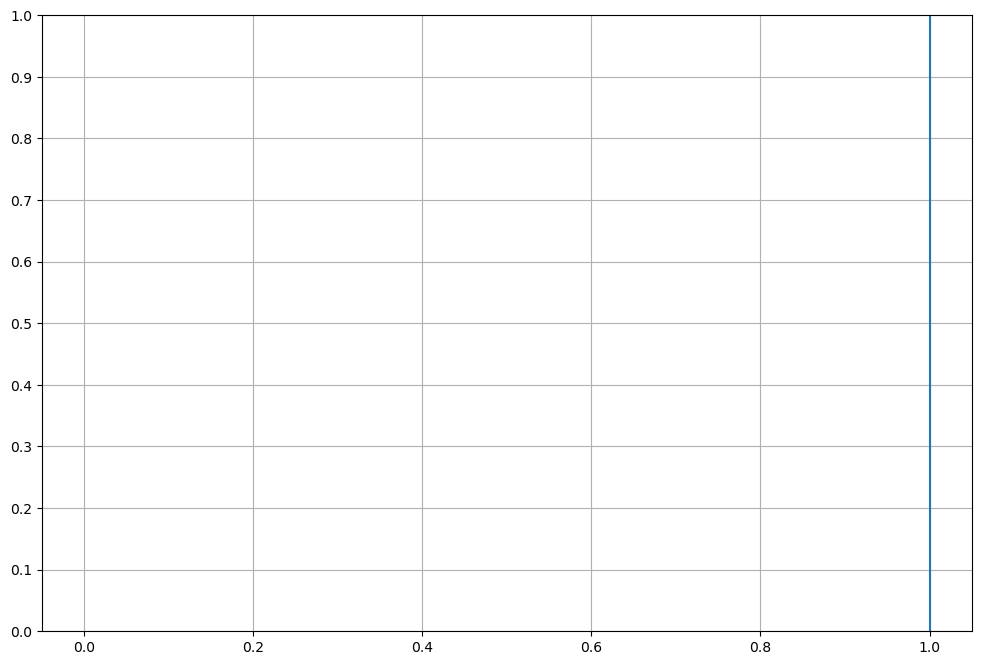

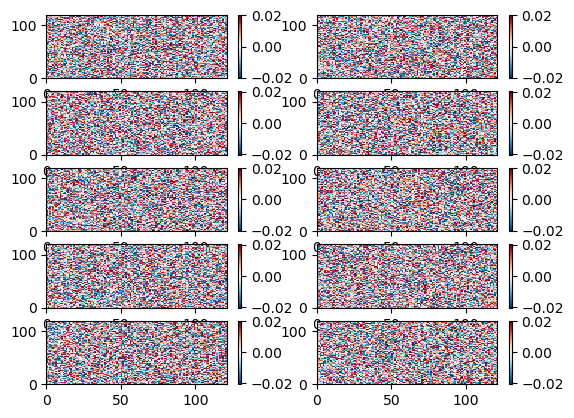

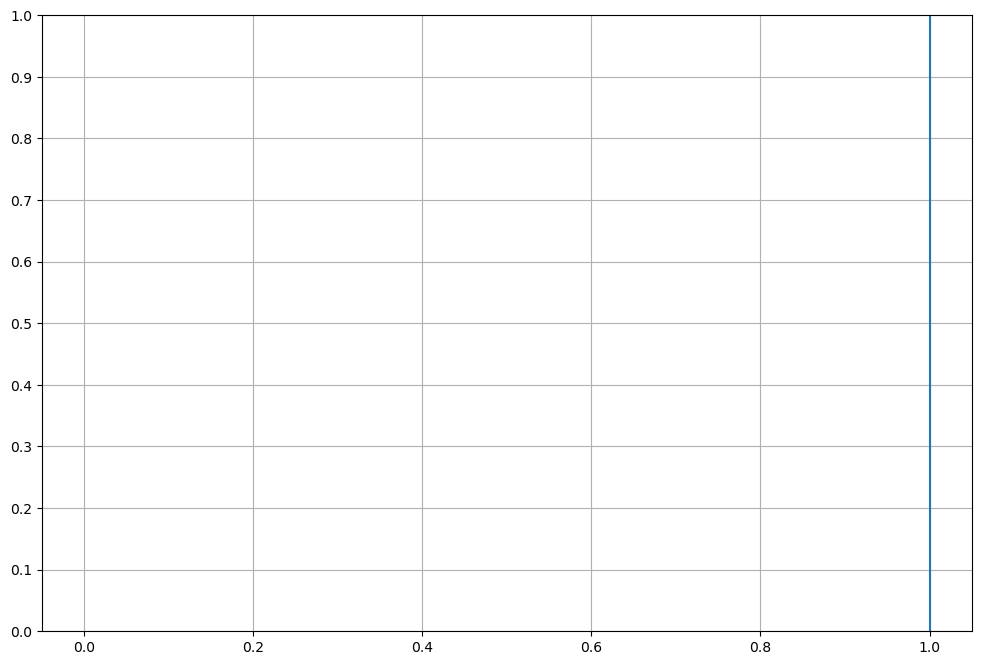

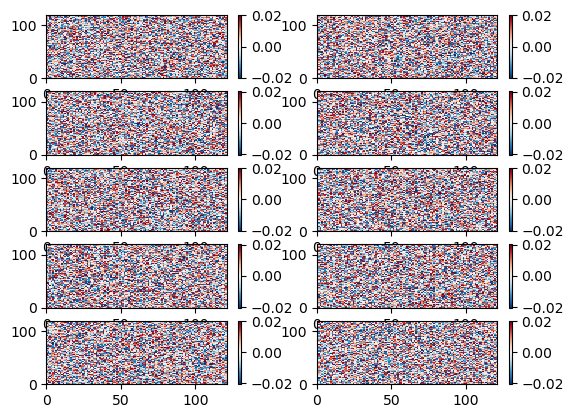

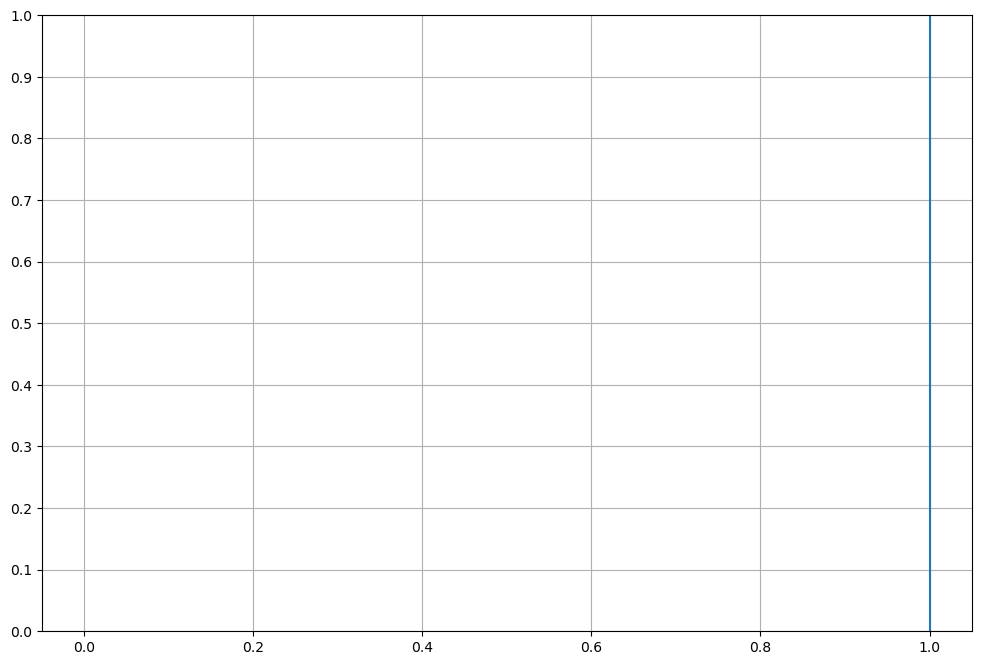

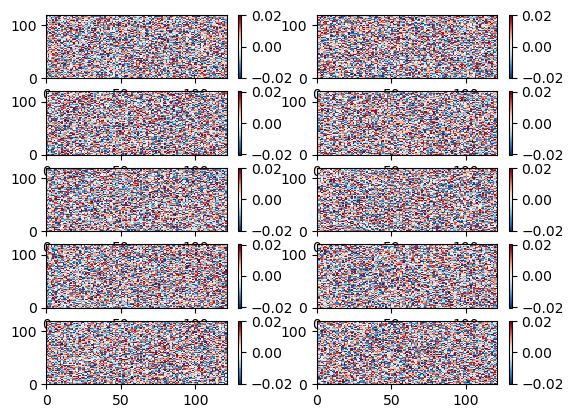

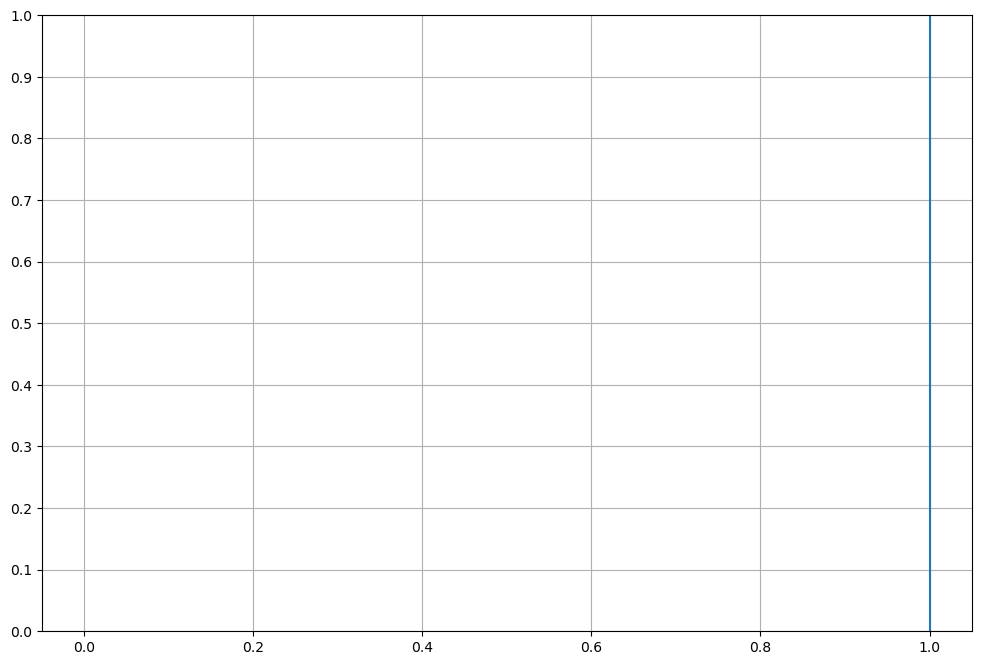

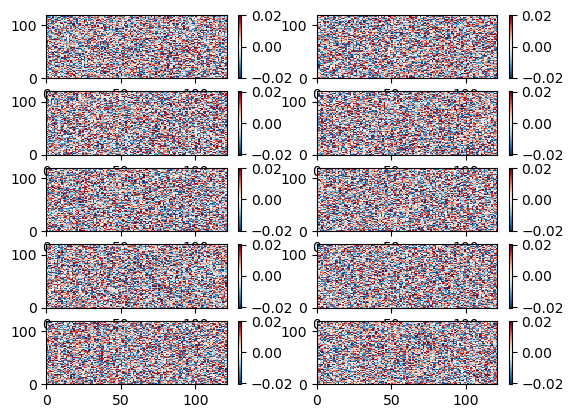

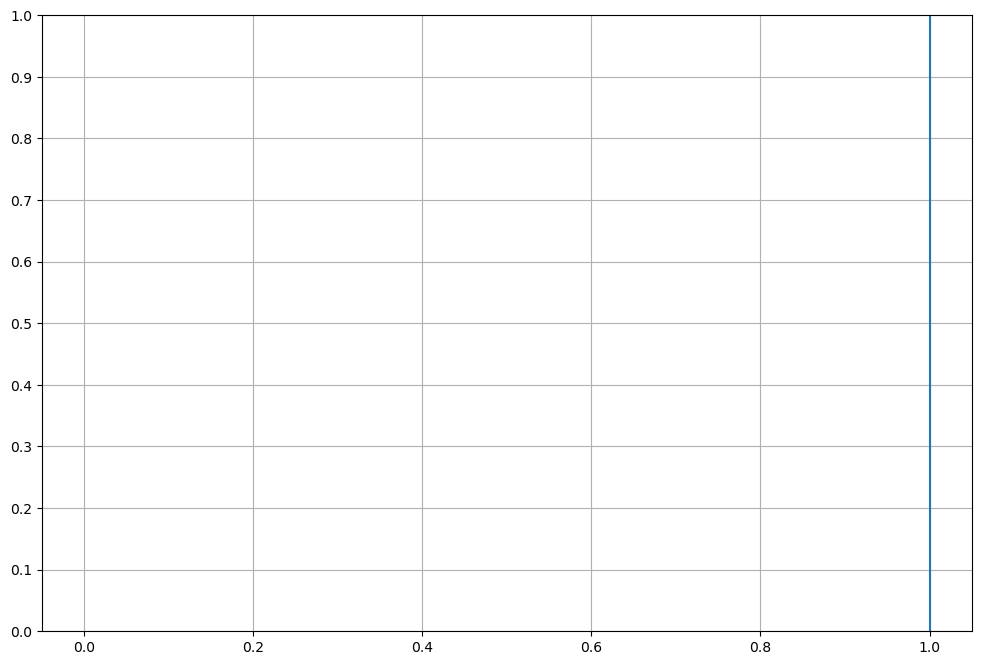

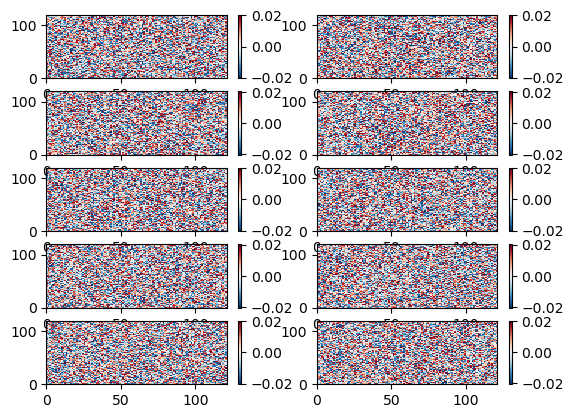

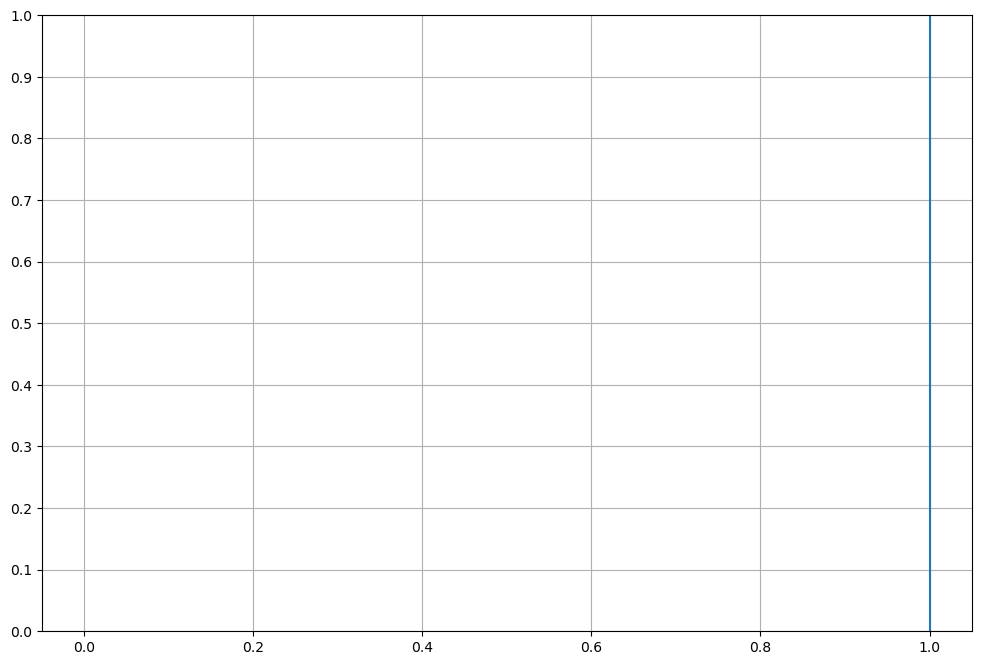

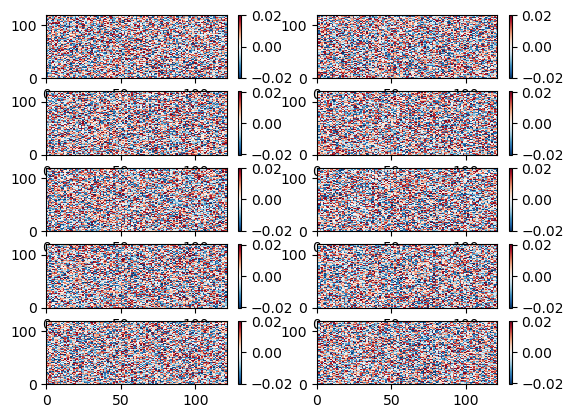

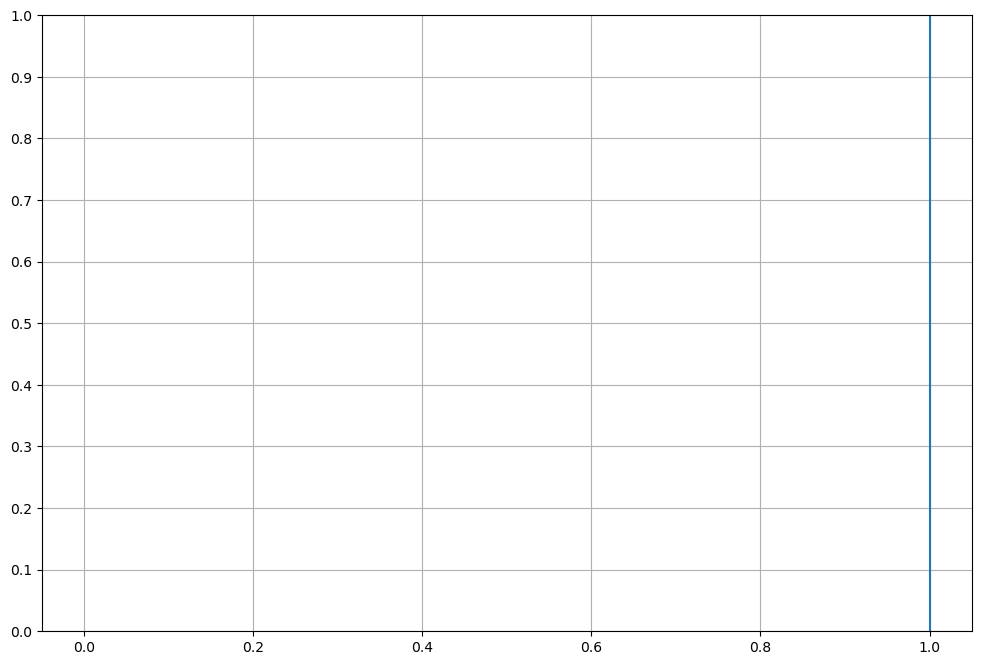

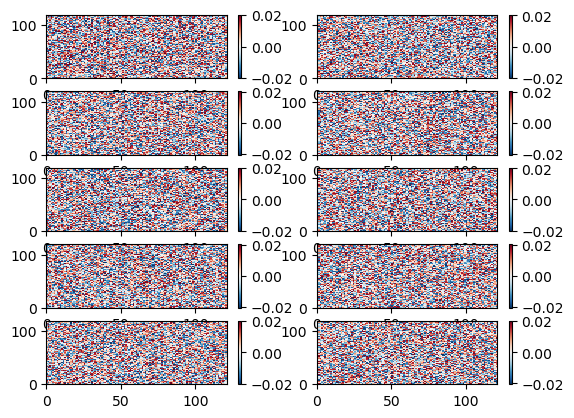

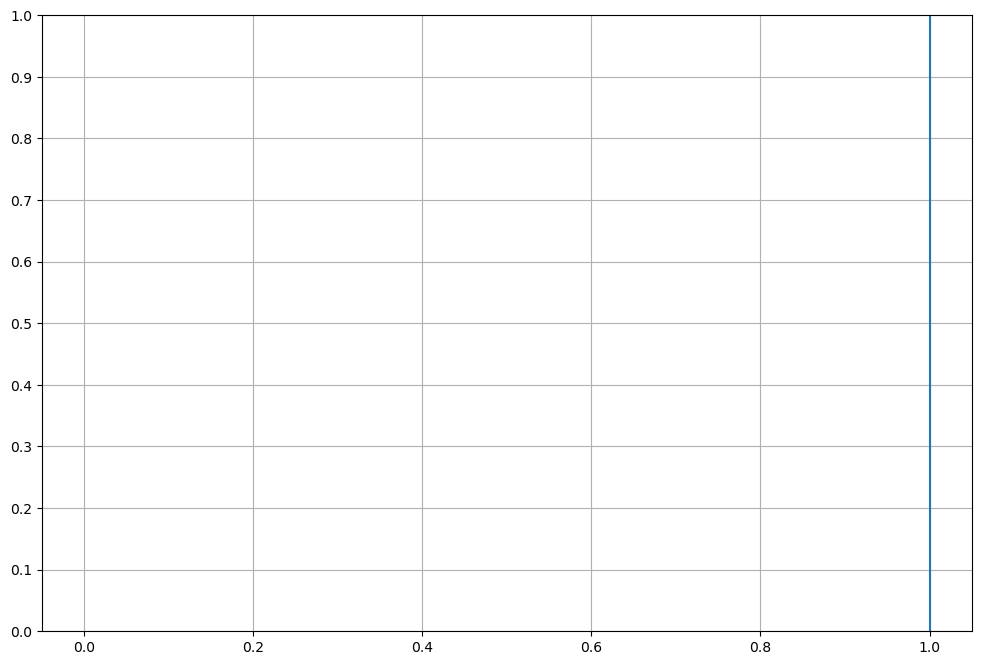

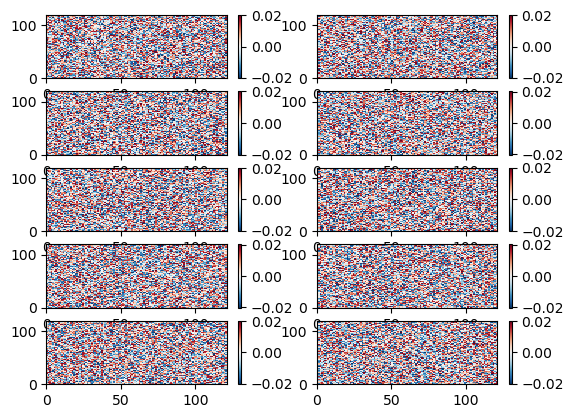

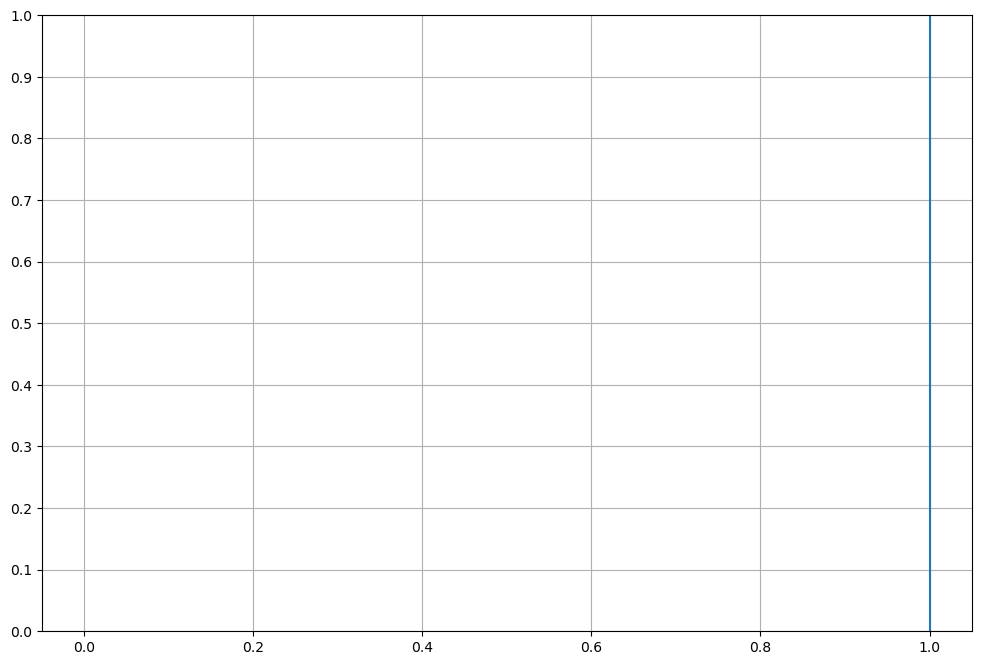

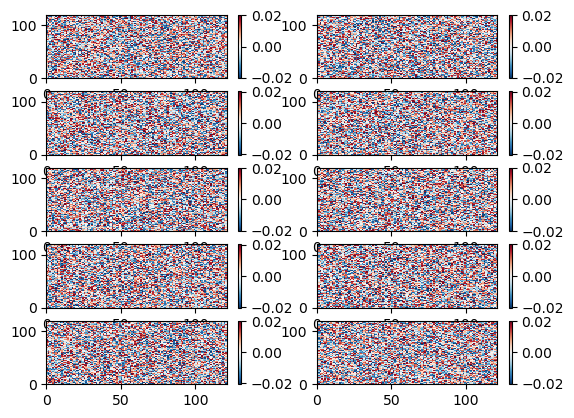

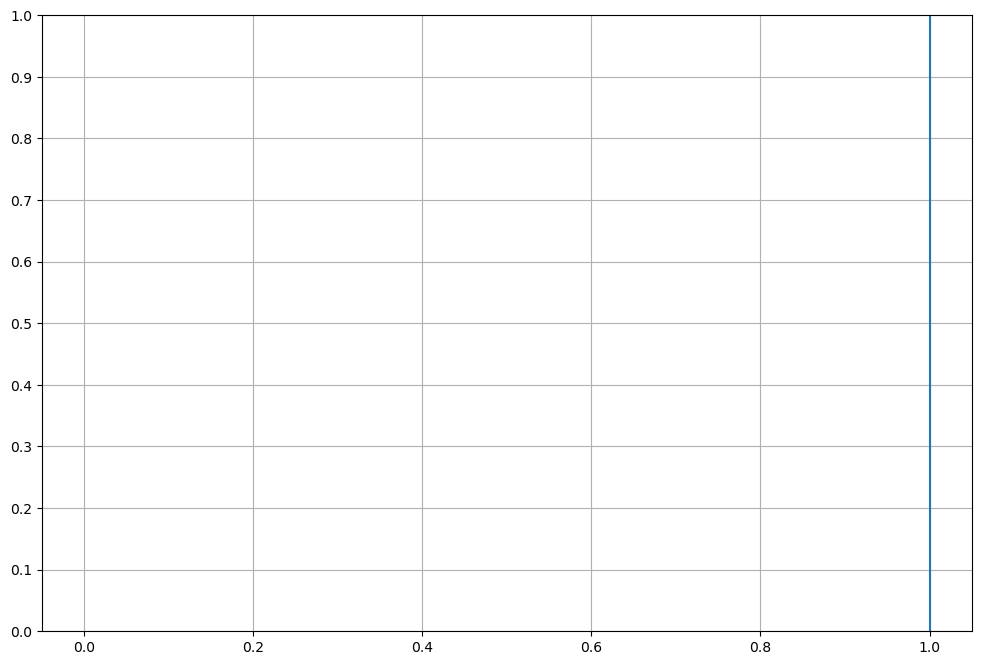

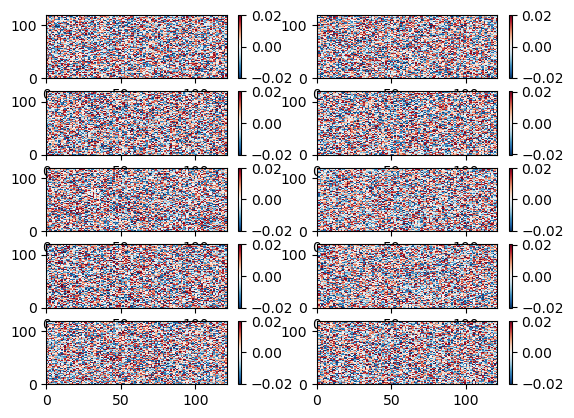

In [28]:
for reg_index, reg_value in enumerate(reg_list):
    model_name = "full_level_{}_kfold_{}_date_{}".format(lev_index, kfold_index, datetime_string)
    model_path = os.path.join(config.model_path, experiment_name, datetime_string,  model_name, "reg_{}".format(reg_index).zfill(3))
    os.makedirs(model_path, exist_ok=True)
    
    model = gen_model(reg_value)
    model.build()
    
    model_file_template = os.path.join(model_path, "saved-model-{epoch:02d}.hdf5")
    checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file_template, monitor='val_mse', verbose=1, save_best_only=False, mode='max')
    csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(model_path, "history.csv"))
    
    opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
    model.compile(optimizer = opt, loss=tf.keras.losses.mse)
    
    
    learning_rate =tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001, decay_steps=100, decay_rate=0.9, staircase=False, name=None)

    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer = opt, loss=tf.keras.losses.mse)
    
    model.fit(x=train_x_ml_np, y=train_y_ml_np, batch_size=15000, epochs=2000, validation_data=(valid_x_ml_np, valid_y_ml_np), callbacks = [TrainValMSEDiff(), checkpoint, csv_logger])
    
    history = pd.read_csv(os.path.join(model_path, "history.csv"))
    history = xr.Dataset.from_dataframe(history)
    
    epoch = np.abs(history["valid_mse_epoch_end"]).argmin()
    
    
    
    plot_path = os.path.join(model_path, "plots")
    os.makedirs(plot_path, exist_ok = True)
    
    plt.figure(figsize=(12,8))
    plt.plot(history["train_mse_epoch_end"])
    plt.plot(history["valid_mse_epoch_end"])
    plt.ylim(0,1)
    plt.yticks(np.arange(0,1.1,0.1))
    plt.axvline(epoch)
    plt.grid()
    
    plt.savefig(os.path.join(plot_path, "training_loss.png"), dpi=300)
    
    
    model_file_template = os.path.join(model_path, "saved-model-{epoch:02d}.hdf5".format(epoch=epoch.values+1))
    model = tf.keras.models.load_model(model_file_template)
    
    weights = xr.DataArray(model.layers[0].get_weights()[0], dims = ["feature","neuron"], coords = {"feature":train_x_xr_stack.feature}).unstack()
    n_neurons = weights.sizes["neuron"]
    
    
    fig, ax = plt.subplots(5,2)
    ax_ravel = np.ravel(ax)
    
    for i in range(n_neurons):
        tmp = weights.isel(neuron=i)
        vmax = np.abs(tmp).max()

        plot = ax_ravel[i].pcolormesh(tmp.transpose("lat","lon"), vmin=-vmax, vmax=vmax, cmap="RdBu_r")
        plt.colorbar(plot, ax = ax_ravel[i])

    plt.savefig(os.path.join(plot_path, "weights.png"), dpi=300)
    

In [31]:
weights.sizes["neuron"]

NameError: name 'weights' is not defined

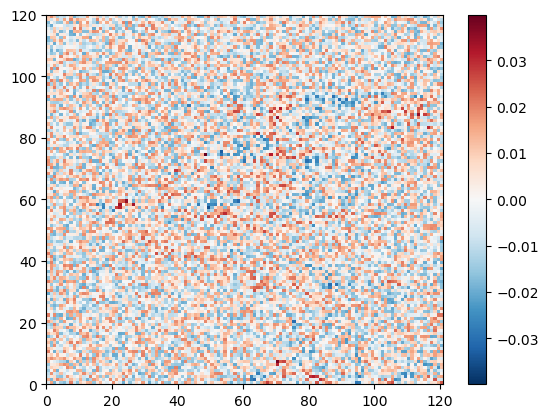

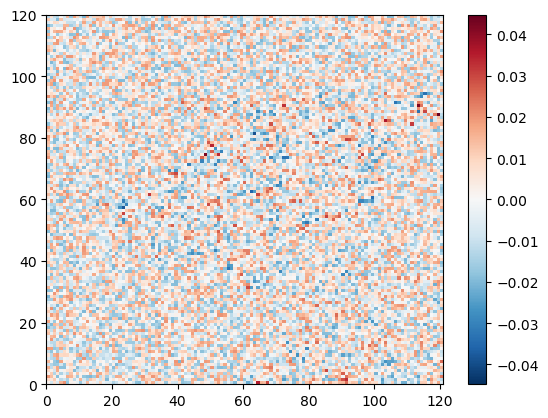

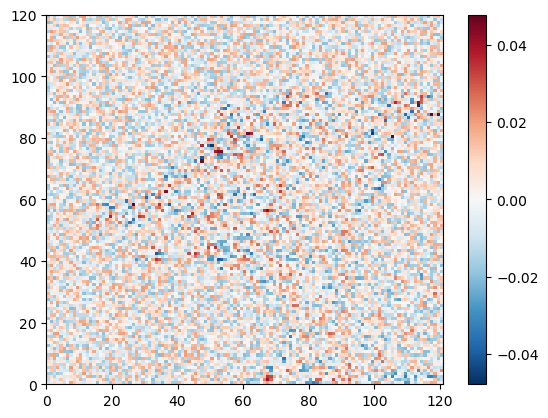

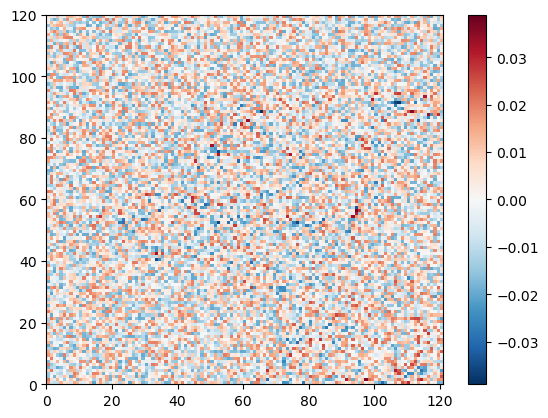

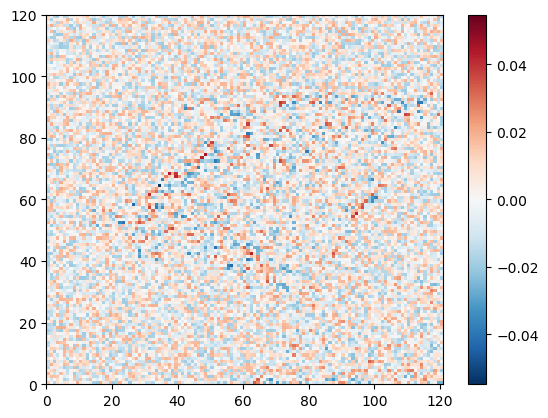

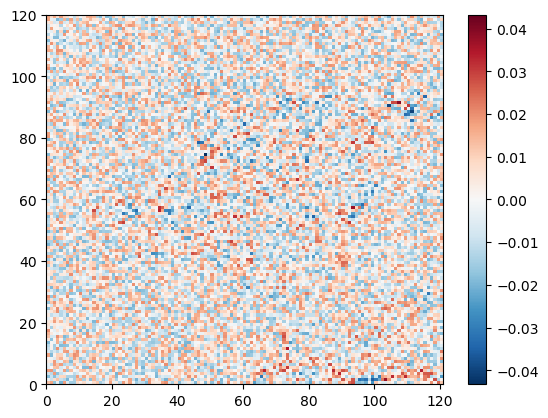

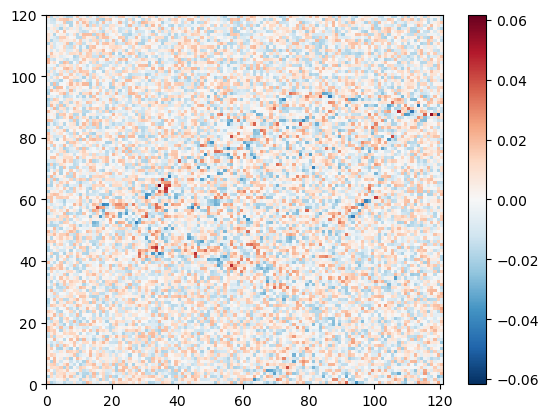

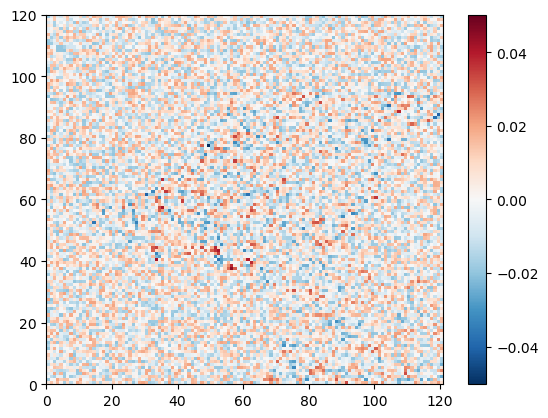

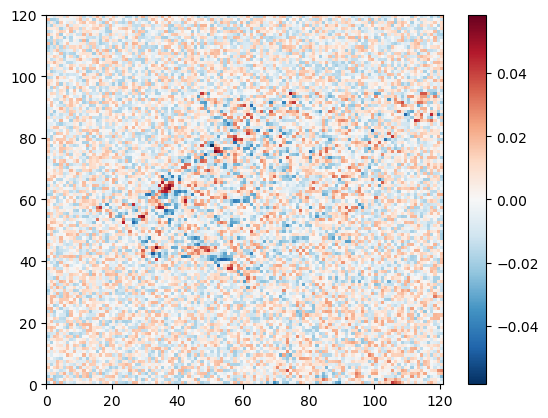

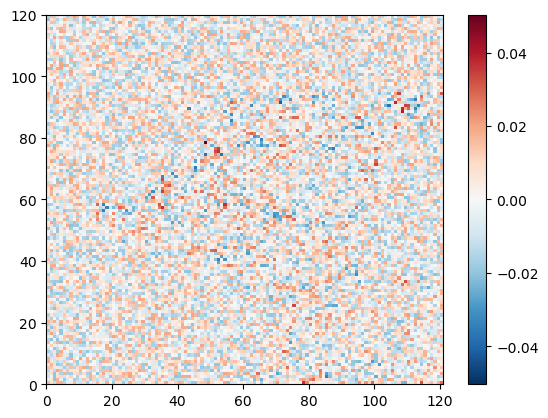

In [29]:
for i in range(10):
    plt.figure()
    tmp = weights.isel(neuron=i)
    vmax = np.abs(tmp).max()

    plot = plt.pcolormesh(tmp.transpose("lat","lon"), vmin=-vmax, vmax=vmax, cmap="RdBu_r")
    plt.colorbar(plot)